# 1. Loading Data and Libraries

In [7]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()

def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()


In [5]:
# General Data Stats
avg_admission_rate = QUERY("""
  SELECT
    CASE
    WHEN is_mh_disorder = 0 THEN 'Non-MH-Diagnosis'
    ELSE 'MH-Disorder'
  END AS is_mh_disorder,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
GROUP BY is_mh_disorder



ORDER BY total_readmissions DESC
""")
avg_admission_rate

,is_mh_disorder,avg_readmissions,total_readmissions,percent_total_readmissions
0,Non-MH-Diagnosis,14.314654,318332,23.16
1,MH-Disorder,14.200670,54329,50.24


Approximately 51% of emergency department admissions for mental health issues were readmissions. Compared to non-mental health related admissions which were only approximately 23%

In [ ]:
# Clean white style
sns.set_style("white")
# Set default palette color to red purple
sns.set_palette('RdPu')

## Age and Mental Health Diagnosis

In [9]:
# 1. What age group has the highest readmission rate?
group_with_highest_readmission = QUERY("""
    SELECT
      p.age_group,
      AVG(r.days_to_readmission) AS avg_num_of_days_to_readmission,
      SUM(r.had_readmission_within_30)AS total_num_of_readmissions,
      ROUND((SUM(r.had_readmission_within_30)/COUNT(*)) * 100,2) AS percent_of_readmissions
    FROM
      `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
    ON
      r.subject_id = p.subject_id
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
    ON
        r.stay_id = d.stay_id
    WHERE d.is_mh_disorder = 1
    GROUP BY p.age_group
    ORDER BY total_num_of_readmissions DESC
""")

In [15]:
group_with_highest_readmission = group_with_highest_readmission.sort_values(by='percent_of_readmissions',ascending=False)

/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_16540/2273120326.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


Text(0.5, -0.12, ' \n    The two highest age groups with the highest proportion of readmissions were those aged 50-59 and 40-59, with proportions of\n    readmissions that were about 72% and 53%, respectively. These groups have significantly different proportions compared to other groups.\n')

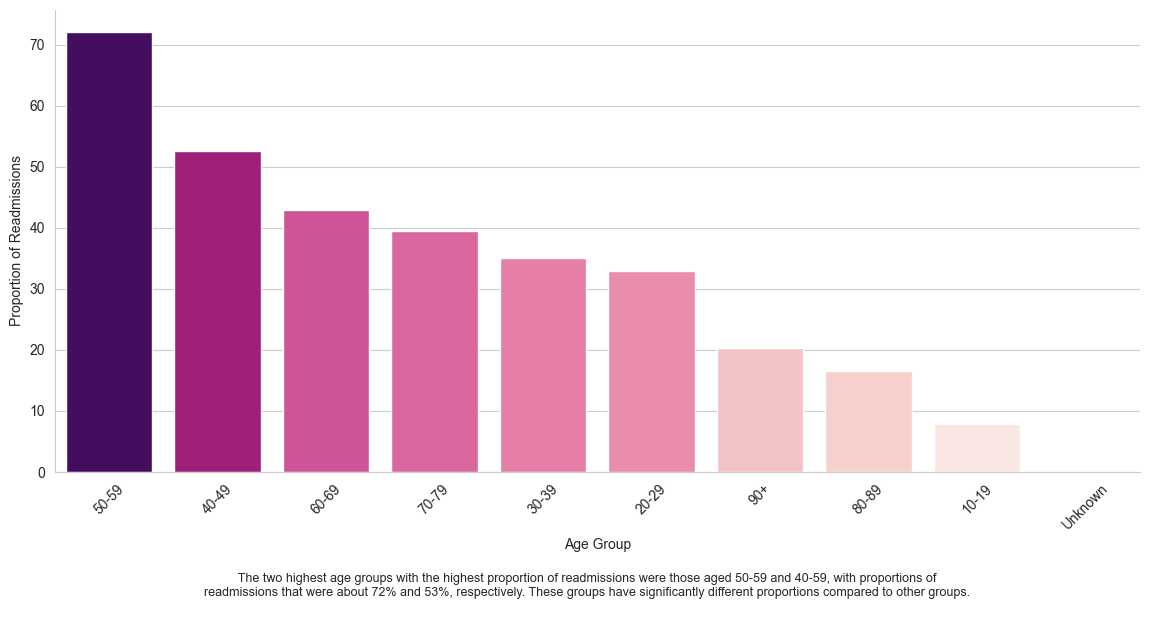

In [16]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(14,6))
sns.barplot(x="age_group", y="percent_of_readmissions",estimator='mean',hue ="percent_of_readmissions",palette='RdPu',data=group_with_highest_readmission,ax=ax1)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend().set_visible(False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Proportion of Readmissions")

caption = """ 
    The two highest age groups with the highest proportion of readmissions were those aged 50-59 and 40-59, with proportions of
    readmissions that were about 72% and 53%, respectively. These groups have significantly different proportions compared to other groups.
"""
fig.text(0.5, -0.12,caption, ha='center', fontsize=9)

In [19]:
#1.1 What are the readmission rates by age group and diagnosis?

age_groups_by_diagnosis = QUERY("""
SELECT
  p.age_group,
  d.mental_health_category,
  SUM(r.had_readmission_within_30) AS total_num_of_readmissions,
  ROUND((SUM(r.had_readmission_within_30)/COUNT(*)) * 100, 2) AS percent_of_readmissions
FROM
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY
  p.age_group, d.mental_health_category
HAVING
  total_num_of_readmissions > 1
ORDER BY
  percent_of_readmissions DESC
""")

In [20]:
age_groups_by_diagnosis = age_groups_by_diagnosis.pivot_table(index='age_group', columns='mental_health_category',values='percent_of_readmissions')

Text(0.5, 1.0, 'Percent of Readmissions by Age Group and Mental Health Diagnosis')

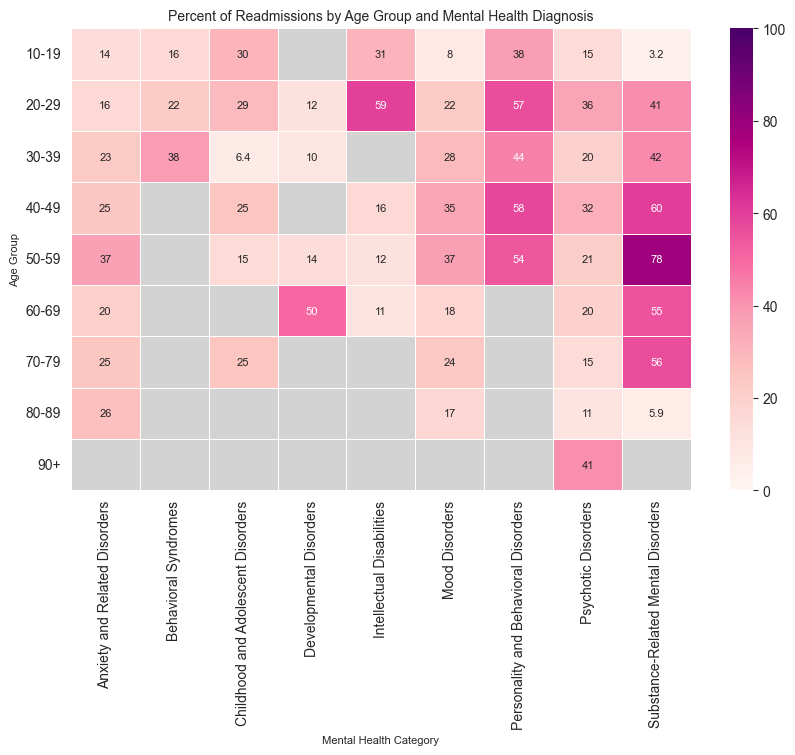

In [21]:
# Create a mask for NaN values
mask = age_groups_by_diagnosis.isnull()

# Create a custom colormap where NaNs appear gray
cmap = sns.color_palette("RdPu", as_cmap=True)
cmap.set_bad(color='lightgray')  # Set NaNs to light gray
fig,ax = plt.subplots(figsize=(10,6))
# Plot the heatmap
sns.heatmap(age_groups_by_diagnosis, mask=mask, cmap=cmap, linewidths=0.5,ax=ax,annot=True,annot_kws=({'size':8}),vmin=0,vmax=100)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('')
ax.set_ylabel('Age Group', fontsize=8)
ax.set_xlabel('Mental Health Category', fontsize=8)
ax.set_title("Percent of Readmissions by Age Group and Mental Health Diagnosis", fontsize=10)

Overall, substance‑related disorders and personality disorders show the highest readmission rates across all age groups, suggesting these patients may be at particularly elevated risk. Notably, individuals in their 50s with a substance‑related diagnosis have a 78% readmission rate—far exceeding any other age‑diagnosis combination.

**Age‑specific highlights:**

**20s**: Among patients in their 20s, those diagnosed with intellectual disabilities exhibit the highest readmission rate compared to other diagnostic categories in this cohort.

**50s**: As noted, substance‑related disorders peak in this decade at 78%, underscoring the vulnerability of middle‑aged patients with these conditions.

**60s**: In patients aged 60, developmental disorders carry the highest readmission rate (50%), indicating a distinct risk pattern in later life.

**90s+**: In patients 90 and older, psychotic disorders have the highest readmission rate (41%), demonstrating that there is a higher risk for these patients as they get much older

These patterns suggest targeted interventions—particularly for substance‑related, personality, intellectual disability, developmental, and psychotic disorders, populations—could help reduce ED bounce‑backs in the highest‑risk age groups.

In [25]:
# 1.2 What age group on average has the highest number of comorbities per patient?
age_groups_by_comorbities = QUERY("""
SELECT
    age_group,
    ROUND(avg(num_comorbities),1) AS avg_num_comorbitites
FROM
    (SELECT
      p.age_group,
      p.subject_id,
      Count(icd_code) AS num_comorbities
      
    FROM
      `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
    ON
      r.subject_id = p.subject_id
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
    ON
      r.stay_id = d.stay_id
    WHERE d.seq_num > 1 AND d.is_mh_disorder = 1
    GROUP BY
      p.age_group,
      p.subject_id
        
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  age_group
ORDER BY
  age_group;
  
""")

In [26]:
age_groups_by_comorbities

,age_group,avg_num_comorbitites
0,10-19,1.5
1,20-29,2.5
2,30-39,3.2
3,40-49,5.6
4,50-59,8.9
5,60-69,3.2
6,70-79,2.7
7,80-89,1.7
8,90+,1.3
9,Unknown,1.3


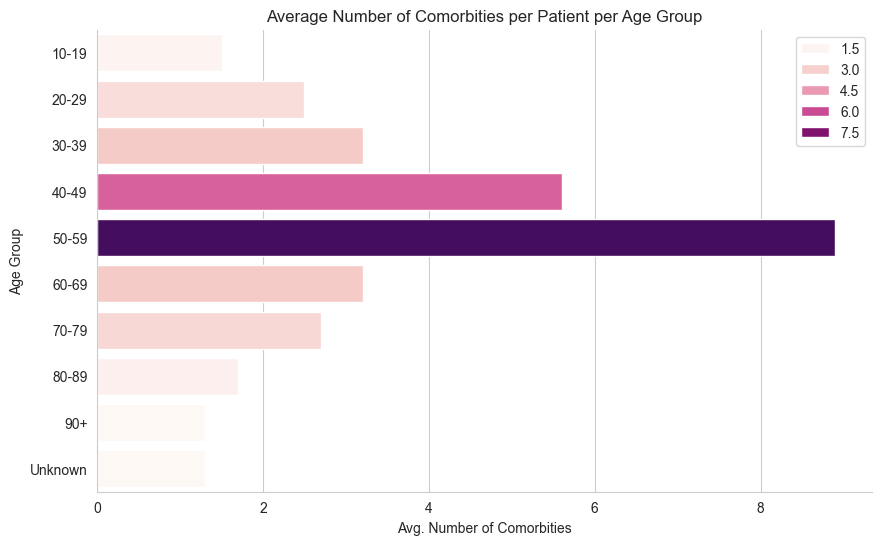

In [28]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(data=age_groups_by_comorbities, x="avg_num_comorbitites", y="age_group",orient='h',hue="avg_num_comorbitites",palette='RdPu')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Age Group')
ax.set_xlabel('Avg. Number of Comorbities')
ax.set_title('Average Number of Comorbities per Patient per Age Group')
ax.legend()

Patients between the ages of 40 - 59, have a higher amount of comorbities on average per patient compared to other age groups indicating that these age groups may suffer from more complex diagnosis and require more targeted intervention.

## Gender and Mental Health Diagnosis

In [37]:
# 1.What gender has the highest readmission rate? 
gender_by_admission = QUERY("""
    SELECT
  gender,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1



GROUP BY gender
ORDER BY total_readmissions DESC
""")
gender_by_admission

,gender,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,14.167023,47480,59.12
1,F,14.530028,6131,23.76


Male patients have more readmissions compared to Women, 59.12% of male admissions to the emergency department are readmissions. The reason this is currently the case is still unclear but it might be due to the differences in the types of diagnosis male patients have versus female patients. Additionally, male patients may suffer from mental health diagnosis that are associated with greater readmission rates as we've seen with diagnosis related to substance abuse. 

In [4]:
# 1.1 What are the top 10 diagnosis category by gender?
top_10_mh_cat_diagnosis_by_gender = QUERY("""
  SELECT
  gender,
  mental_health_category,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions


FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1


GROUP BY gender,mental_health_category
ORDER BY gender DESC, percent_total_readmissions DESC
""")

In [5]:
top_10_mh_cat_diagnosis_by_gender

,gender,mental_health_category,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,Substance-Related Mental Disorders,14.115054,41759,66.75
1,M,Personality and Behavioral Disorders,14.341014,181,52.77
2,M,Mood Disorders,14.797210,3400,33.90
3,M,Psychotic Disorders,14.473930,1269,33.02
4,M,Intellectual Disabilities,18.112903,47,29.56
5,M,Anxiety and Related Disorders,13.243876,754,25.36
6,M,Childhood and Adolescent Disorders,14.512500,56,22.05
7,M,Behavioral Syndromes,20.571429,8,12.90
8,M,Developmental Disorders,12.571429,6,7.14
9,M,Unspecified Mental Disorders,NaN,0,0.00


Among male patients admitted to the emergency department for Substance-Related Mental Health Disorders and Personality and Behavioral Disorders, 67% and 53%, respectively, were readmitted for the same conditions. In contrast, among female patients admitted for these disorders, the pattern is reversed: 55% of those admitted for Personality and Behavioral Disorders were readmissions, compared to 29% for Substance-Related Mental Health Disorders. These two conditions represent the most common reasons for readmission to the emergency department in both male and female patients.

In [6]:
# 1.2 What are the top 10 icd codes?
top_10_mh_icd_diagnosis_by_gender = QUERY("""
  SELECT
  gender,
  icd_title,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions


FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1


GROUP BY gender,icd_title
ORDER BY gender DESC, total_readmissions DESC
LIMIT 10
""")

In [7]:
top_10_mh_icd_diagnosis_by_gender

,gender,icd_title,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,"Alcohol abuse with intoxication, unspecified",14.105524,17554,74.64
1,M,ALCOHOL ABUSE-UNSPEC,13.840377,10084,64.20
2,M,"Alcohol dependence with intoxication, unspecified",14.465333,5250,79.10
3,M,AC ALCOHOL INTOX-UNSPEC,14.415229,3020,68.53
4,M,"Major depressive disorder, single episode, uns...",14.574786,1661,38.31
5,M,DEPRESSIVE DISORDER,15.674635,1324,34.63
6,M,AC ALCOHOL INTOX-CONTIN,13.748915,1137,78.36
7,M,ALCOH DEP NEC/NOS-UNSPEC,14.232947,649,44.00
8,M,ALCOHOL WITHDRAWAL,14.812367,426,42.94
9,M,DRUG ABUSE NEC-UNSPEC,14.584245,410,47.56


Diving further into the specific ICD codes within the mental health categories, an analysis of the top 10 mental health diagnoses—ranked by both the number and percentage of readmissions—reinforces our earlier findings. Substance-Related Disorders continue to account for a significant portion of readmissions, along with Personality and Behavioral Disorders, particularly Depressive Disorder and Major Depressive Disorder in this case.

## Race and Mental Health Diagnosis

In [16]:
#1. What are the readmission rates and average length of stay(ALOS) by racial group?
race_group_readmission_rates = QUERY("""
SELECT  
  race_group,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions,
  AVG(LOS_hr) AS ALOS
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id

GROUP BY race_group
ORDER BY percent_total_readmissions DESC
""")

In [17]:
race_group_readmission_rates

,race_group,total_readmissions,percent_total_readmissions,ALOS
0,American Indian / Alaska Native,1386,46.32,7.799799
1,Black / African American,55509,32.49,7.917169
2,Hispanic / Latino,18419,26.19,7.421661
3,Multiple Race / Ethnicity,267,23.00,6.869940
4,White,79400,22.15,7.636715
5,Other,9935,21.59,7.332355
6,Unknown / Declined / Unable to Obtain,2897,19.50,5.797913
7,Native Hawaiian / Pacific Islander,151,18.37,7.152068
8,Asian,3382,14.08,6.807710


In [20]:
#1.1 What are the readmission rates and average length of stay(ALOS) by race?
race_readmission_rates = QUERY("""
SELECT  
  race,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions,
  AVG(LOS_hr) AS ALOS
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id

GROUP BY race
ORDER BY percent_total_readmissions DESC
""")

In [21]:
race_readmission_rates

,race,total_readmissions,percent_total_readmissions,ALOS
0,BLACK/AFRICAN,6780,50.88,9.081426
1,AMERICAN INDIAN/ALASKA NATIVE,1386,46.32,7.799799
2,HISPANIC/LATINO - CUBAN,553,34.09,7.606042
3,HISPANIC/LATINO - HONDURAN,667,33.02,8.186634
4,BLACK/AFRICAN AMERICAN,45599,32.70,7.910612
5,HISPANIC OR LATINO,5867,32.69,7.351145
6,PORTUGUESE,892,30.15,8.097668
7,HISPANIC/LATINO - PUERTO RICAN,7701,29.48,7.656970
8,PATIENT DECLINED TO ANSWER,530,27.29,7.033986
9,MULTIPLE RACE/ETHNICITY,267,23.00,6.869940


Patients identifying as Black/African American and American Indian/Alaska Native appear to be at greater risk for readmission, with rates of 51% and 46%, respectively—significantly higher than those of other groups. Additionally, Black/African patients have a greater average length of stay compared to all other groups. These disparities highlight the need for more targeted interventions and further investigation into potential underlying causes, such as cultural or socioeconomic barriers that may impact access to care and continuity of treatment.

In [37]:
#1.2 What diagnoses are associated with higher readmission rates by race?
readmission_rates_by_race_and_mental_health_cat = QUERY("""
SELECT  
  race,
  mental_health_category,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions,
  AVG(LOS_hr) AS ALOS
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1

GROUP BY race,mental_health_category
HAVING
    total_readmissions > 20
ORDER BY percent_total_readmissions DESC
""")

In [38]:
readmission_rates_by_race_and_mental_health_cat

,race,mental_health_category,total_readmissions,percent_total_readmissions,ALOS
0,BLACK/AFRICAN,Substance-Related Mental Disorders,5172,90.85,11.504830
1,PORTUGUESE,Substance-Related Mental Disorders,318,83.03,10.584856
2,HISPANIC/LATINO - CUBAN,Substance-Related Mental Disorders,221,79.78,8.386282
3,BLACK/AFRICAN AMERICAN,Substance-Related Mental Disorders,16762,76.56,10.484586
4,HISPANIC OR LATINO,Substance-Related Mental Disorders,2386,70.51,9.963357
5,HISPANIC/LATINO - PUERTO RICAN,Substance-Related Mental Disorders,2489,66.20,10.119681
6,UNKNOWN,Substance-Related Mental Disorders,1629,65.45,9.171555
7,HISPANIC/LATINO - HONDURAN,Substance-Related Mental Disorders,420,65.12,10.547287
8,HISPANIC/LATINO - CUBAN,Mood Disorders,43,61.43,10.785714
9,AMERICAN INDIAN/ALASKA NATIVE,Anxiety and Related Disorders,36,61.02,8.779661


As seen throughout our analysis, Substance-Related Mental Health Disorders consistently emerge as a leading cause of emergency department readmissions—a trend that aligns with the chronic and relapsing nature of these conditions. From this analysis of the top 10 demographic groups, we identified those at greater risk of readmission when diagnosed with a Substance-Related Disorder, Mood Disorder, Anxiety and Related Disorder, or Personality and Behavioral Disorder. These groups include:

Black/African

Portuguese

Hispanic/Latino – Cuban

Black/African American

Hispanic or Latino

Hispanic/Latino – Puerto Rican

Unknown

Hispanic/Latino – Honduran

American Indian/Alaska Native

White
    

## Marital Status and Mental Health Diagnosis

In [43]:
#1. What are readmission rates by martial status? how do readmission rates differ?
readmission_rate_by_marital_status = QUERY("""
SELECT
  marital_status,
  -- Percentage of patients with this marital status who were readmitted
  SUM(had_readmission_within_30) * 100.0 / COUNT(*) AS percent_of_readmission,

  -- Bayes' Theorem: P(marital_status | readmitted)
  ((
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1
  ) / (
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1 +
    (SUM(CASE WHEN had_readmission_within_30 = 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)) * 71.9
  )) * 100 AS bayes_p_marital_given_readmitted
  

FROM
  `patient_info.MH-ED-READMISSIONS` AS r
LEFT JOIN 
  `patient_info.MH-PATIENT-DEMO` AS p
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY
  marital_status
ORDER BY percent_of_readmission DESC
""")

In [44]:
readmission_rate_by_marital_status

,marital_status,percent_of_readmission,bayes_p_marital_given_readmitted
0,DIVORCED,57.135187,34.250795
1,SINGLE,56.260742,33.453251
2,WIDOWED,55.436856,32.713557
3,MARRIED,27.563473,12.946179
4,None,8.021642,3.296090


All groups exhibit high rates of readmission, with the exception of patients who are married or categorized as 'None,' suggesting these individuals may be at lower risk of returning to the emergency department. In fact, using Bayes’ Theorem, we found that the probability of a patient being married given that they were readmitted is approximately 13%, further supporting the idea that married individuals are less likely to be readmitted. This reinforces the potential protective role of social support. As such, it may be beneficial to develop targeted interventions for patients with limited social support—particularly those who are unmarried or without a stable support system—to help reduce readmission rates.

In [46]:
#1.1 What are readmission rates by martial status and mental health diagnosis category?
readmission_rate_by_marital_status_and_mh_cat = QUERY("""
SELECT
  marital_status,
  mental_health_category,
  -- Percentage of patients with this marital status who were readmitted
  SUM(had_readmission_within_30) * 100.0 / COUNT(*) AS percent_of_readmission,

  -- Bayes' Theorem: P(marital_status | readmitted)
  ((
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1
  ) / (
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1 +
    (SUM(CASE WHEN had_readmission_within_30 = 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)) * 71.9
  )) * 100 AS bayes_p_marital_given_readmitted
  

FROM
  `patient_info.MH-ED-READMISSIONS` AS r
LEFT JOIN 
  `patient_info.MH-PATIENT-DEMO` AS p
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1 AND mental_health_category IS NOT NULL
GROUP BY
  marital_status,mental_health_category
ORDER BY percent_of_readmission DESC
""")

In [47]:
readmission_rate_by_marital_status_and_mh_cat

,marital_status,mental_health_category,percent_of_readmission,bayes_p_marital_given_readmitted
0,WIDOWED,Personality and Behavioral Disorders,76.315789,55.738714
1,SINGLE,Substance-Related Mental Disorders,67.939844,45.301453
2,DIVORCED,Substance-Related Mental Disorders,65.574009,42.674620
3,WIDOWED,Substance-Related Mental Disorders,62.739726,39.689021
4,WIDOWED,Mood Disorders,54.393939,31.793141
5,SINGLE,Personality and Behavioral Disorders,53.465347,30.988217
6,MARRIED,Personality and Behavioral Disorders,52.631579,30.276910
7,WIDOWED,Intellectual Disabilities,50.000000,28.100000
8,DIVORCED,Personality and Behavioral Disorders,48.484848,26.891561
9,WIDOWED,Psychotic Disorders,46.305419,25.207806


Social support may play a **protective role**. Notably, **married individuals and those categorized as 'None'** for marital status have the **lowest readmission rates**.

Using **Bayes’ Theorem**, we found that the **probability of being married given readmission is only 13%**, reinforcing the idea that **social support systems may reduce the risk of ED return**.

This finding supports the implementation of **interventions that target socially isolated individuals** to improve mental health outcomes.


# Emergency Department Readmissions for Mental Health: Key Findings and Implications

Our analysis reveals that **approximately 51%** of emergency department (ED) admissions for mental health issues are **readmissions**, underscoring the persistent challenge of recurring psychiatric crises. The burden of readmission is not evenly distributed; distinct patterns emerge across age, sex, diagnosis, race/ethnicity, and social support indicators.

## Age and Readmission Patterns

Patients in the **50–59** and **40–49** age groups exhibit the **highest readmission proportions** at approximately **72%** and **53%**, respectively—significantly higher than those observed in other age groups. Additionally, individuals in higher age brackets tend to experience **longer intervals between readmissions**, suggesting differences in disease progression or treatment access across age.

### Age-specific highlights:
- **20s**: Intellectual disabilities show the highest readmission rate.
- **50s**: Substance-related disorders spike at **78%** readmission.
- **60s**: Developmental disorders lead with **50%** readmissions.
- **90s+**: Psychotic disorders are most frequent, at **41%**.

Patients aged **40–59** also have the **highest average number of comorbidities**, suggesting that complex diagnoses may drive elevated readmission risk and should be a priority for targeted intervention.

## Sex Differences in Readmission

Male patients exhibit **higher readmission rates (59.1%)** compared to female patients. While the exact cause remains uncertain, this trend may be influenced by the **prevalence of substance-related diagnoses in men**, which consistently rank among the most frequent causes of ED readmission.

## Diagnostic Trends

Across all demographics, **substance-related disorders** and **personality/behavioral disorders** emerge as the **top drivers of readmissions**. In particular:

- Among **men**, readmission rates for:
  - Substance-related disorders: **67%**
  - Personality/behavioral disorders: **53%**

- Among **women**, the pattern is reversed:
  - Personality/behavioral disorders: **55%**
  - Substance-related disorders: **29%**

Drilling down into **ICD codes**, the top 10 mental health diagnoses—based on both volume and readmission percentage—consistently feature:

- **Substance-Related Disorders**
- **Depressive Disorders** (e.g., Major Depressive Disorder)

These findings highlight the **chronic nature** of these conditions and the critical need for **proactive, ongoing care post-discharge**.

## Disparities in Race and Ethnicity

Patients identifying as **Black/African American (51%)** and **American Indian/Alaska Native (46%)** have **disproportionately high readmission rates**. Additionally, Black/African patients experience **longer average stays** in the ED. These disparities suggest the presence of **systemic barriers—cultural, socioeconomic, or access-related**—that warrant further investigation and **tailored interventions**.

### High-risk groups include:
- Black/African
- Portuguese
- Hispanic/Latino – Cuban
- Black/African American
- Hispanic or Latino
- Hispanic/Latino – Puerto Rican
- Unknown
- Hispanic/Latino – Honduran
- American Indian/Alaska Native
- White

## The Role of Social Support

Social support may play a **protective role**. Notably, **married individuals and those categorized as 'None'** for marital status have the **lowest readmission rates**.

Using **Bayes’ Theorem**, we found that the **probability of being married given readmission is only 13%**, reinforcing the idea that **social support systems may reduce the risk of ED return**.

This finding supports the implementation of **interventions that target socially isolated individuals** to improve mental health outcomes.

---

## Next Steps: Predictive Modeling for Targeted Care

Given the consistent impact of **Substance-Related Mental Health Disorders** on readmission across age, sex, and racial groups, the next step involves the development of a **machine learning model** to **predict individual risk of ED readmission** for these diagnoses.

Such a model could empower healthcare providers to:
- Identify high-risk patients at the point of discharge
- Prioritize care plans
- Tailor follow-up strategies
- Ultimately, **reduce avoidable readmissions** and improve patient outcomes